<a href="https://colab.research.google.com/github/kolbrak/Modulation_Classification/blob/master/Modulation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses

#Tried the new RAdam optimizer.  Didn't seem to work as well as the "normal" adam optimizer.
#!pip install keras-rectified-adam 
#from keras_radam import RAdam

%matplotlib inline
import os,random
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

In [0]:
tf.test.gpu_device_name() 

'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#This line checks that the drive was mounted
!ls "/content/gdrive/My Drive/Colab Notebooks/"

model.h5    model.png			     RML2016.10a_dict.pkl
model.json  Modulation_Classification.ipynb


In [0]:
# Load the dataset ...
#  You will need to seperately download or generate this file
# The output format looks like this
# {('mod type', SNR): np.array(nvecs_per_key, 2, vec_length), etc}
#Xd = pickle.load(open("gdrive/My Drive/Colab Notebooks/RML2016.10a_dict.pkl",'rb'), encoding='Latin1')
Xraw = pickle.load(open("gdrive/My Drive/Colab Notebooks/RML2016.10a_dict.pkl",'rb'), encoding='Latin1')

#This for loop takes out the low SNR signals and keeps only items with SNR greater than the SNR value
Xd = {}
SNR = 6
for key in Xraw.keys():
  if key[1] > SNR:
    Xd[key] = Xraw[key]

print(Xd[('QPSK', 10)].shape)

(1000, 2, 128)


In [0]:
#Separate out SNR and Modulation from the Xd.keys() and put into two lists
snr = []
mod = []
for key in Xd.keys():
  snr.append(key[1])
  mod.append(key[0])
LABELS = list(dict.fromkeys(mod))
SNR = list(dict.fromkeys(snr))
print(LABELS)
print(SNR)

['PAM4', 'QAM64', 'AM-SSB', '8PSK', 'AM-DSB', 'CPFSK', 'QAM16', 'QPSK', 'GFSK', 'BPSK', 'WBFM']
[8, 12, 16, 10, 14, 18]


In [0]:
test = np.asarray(Xd[('QPSK', 10)][0,:])
test_reshaped = np.expand_dims(test.T,0)

MULTI_LABELS = []
lbl_multidict = {}
snr = []
i = 0

#decimal encode all dictionary itesms
for key in Xd.keys():
  lbl_multidict[key] = key[0]
  #snr.append(key[1])
  i += 1
print('lbl_multidict:',lbl_multidict)
#print(np.asarray(snr).shape)
  
data_list = list()
for key in Xd.keys():
  for i in range(1000):
    data_list.append(np.expand_dims(Xd[key][i,:].T,0)) #list.append(np.expand_dims(Xd[key][i,:].T,0)
    MULTI_LABELS.append(lbl_multidict[key])
    snr.append(key[1])
print('MULTI_LABELS=', MULTI_LABELS)
data_array = np.asarray(np.vstack(data_list))
MULTI_LABELS = np.asarray(MULTI_LABELS).reshape(1, -1).T  #MULTI_LABELS = np.asarray(MULTI_LABELS).reshape(1, -1).T
print('shape of data to load into the CNN:', data_array.shape)
print('shape of the ydata:', MULTI_LABELS.shape)
print('shape of snr:', np.asarray(snr).reshape(1,-1).T.shape)
#from keras.utils import to_categorical
#ydata_binary = to_categorical(MULTI_LABELS)

from sklearn.preprocessing import OneHotEncoder
encode = OneHotEncoder()
#lbl_encode = OneHotEncoder()
ydata_binary = encode.fit_transform(MULTI_LABELS).toarray()
#Y_LABELS = lbl_encode.fit_transform(np.asarray(LABELS).reshape(1,-1))
print(ydata_binary[1])
print(ydata_binary.shape)
#print('LABELS:', LABELS)
#print('Y_LABELS', Y_LABELS)

lbl_multidict: {('PAM4', 8): 'PAM4', ('QAM64', 8): 'QAM64', ('AM-SSB', 12): 'AM-SSB', ('8PSK', 8): '8PSK', ('8PSK', 12): '8PSK', ('AM-DSB', 16): 'AM-DSB', ('CPFSK', 10): 'CPFSK', ('QAM16', 12): 'QAM16', ('QPSK', 8): 'QPSK', ('PAM4', 14): 'PAM4', ('GFSK', 12): 'GFSK', ('AM-DSB', 8): 'AM-DSB', ('BPSK', 16): 'BPSK', ('CPFSK', 16): 'CPFSK', ('BPSK', 14): 'BPSK', ('AM-SSB', 8): 'AM-SSB', ('GFSK', 18): 'GFSK', ('QAM64', 18): 'QAM64', ('WBFM', 10): 'WBFM', ('GFSK', 10): 'GFSK', ('8PSK', 10): '8PSK', ('WBFM', 12): 'WBFM', ('QPSK', 12): 'QPSK', ('PAM4', 10): 'PAM4', ('QAM64', 14): 'QAM64', ('AM-SSB', 18): 'AM-SSB', ('CPFSK', 12): 'CPFSK', ('PAM4', 18): 'PAM4', ('BPSK', 10): 'BPSK', ('8PSK', 16): '8PSK', ('WBFM', 18): 'WBFM', ('QAM16', 10): 'QAM16', ('CPFSK', 8): 'CPFSK', ('QPSK', 16): 'QPSK', ('QPSK', 10): 'QPSK', ('GFSK', 14): 'GFSK', ('AM-DSB', 14): 'AM-DSB', ('CPFSK', 18): 'CPFSK', ('BPSK', 12): 'BPSK', ('QAM64', 10): 'QAM64', ('AM-SSB', 14): 'AM-SSB', ('WBFM', 8): 'WBFM', ('PAM4', 16): 'PAM

Data is processed.  Column data are a two variable label composed of the Modulation and SNR, Row 0 is the binary encoded version of the Modulation and SNR,
Row 1 is the actual data, each column is a 2, 128 array of I and Q data for the specified Modulation and SNR in the column label

In [0]:
#This splits the ENCODED_X dataframe into Train and Test sets
from sklearn.model_selection import train_test_split, ShuffleSplit
xTrain, xTest, yTrain, yTest = train_test_split(data_array, ydata_binary, test_size = 0.3, random_state = 0)
snr_train, snr_test = train_test_split(np.asarray(snr), test_size = 0.3, random_state = 0)  #This should work because I initialize the random state so it will always come up with the same indexes
print('xTrain.shape:', xTrain.shape)
print('xTest.shape:', xTest.shape)
print('yTrain.shape:', yTrain.shape)
print('yTest.shape:', yTest.shape)
print('snr_train.shape:', snr_train.shape)
print('snr_test.shape:', snr_test.shape)

xTrain.shape: (46200, 128, 2)
xTest.shape: (19800, 128, 2)
yTrain.shape: (46200, 11)
yTest.shape: (19800, 11)
snr_train.shape: (46200,)
snr_test.shape: (19800,)


Now we build the CNN

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten

verbose, epochs, batch_size = 1, 256, 1024
n_timesteps, n_features, n_outputs = xTrain.shape[1], xTrain.shape[2], yTrain.shape[1]
print('timesteps=', n_timesteps, 'features=', n_features, 'outputs=', n_outputs)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(RAdam(), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

timesteps= 128 features= 2 outputs= 11
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 126, 64)           448       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 124, 64)           12352     
_________________________________________________________________
dropout_7 (Dropout)          (None, 124, 64)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 62, 64)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3968)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               396900    
_________________________________________________________________
dense_14 (Dense)             (None, 1

In [0]:
#Train the model
print(xTrain.shape, yTrain.shape)
model.fit(xTrain, yTrain, batch_size=batch_size, epochs=epochs, verbose=verbose)


(46200, 128, 2) (46200, 11)
Epoch 1/256
46200/46200 [==============================] - 1s 29us/step - loss: 2.2563 - acc: 0.1835
Epoch 2/256
46200/46200 [==============================] - 1s 17us/step - loss: 2.0399 - acc: 0.2609
Epoch 3/256
46200/46200 [==============================] - 1s 17us/step - loss: 1.8145 - acc: 0.3138
Epoch 4/256
46200/46200 [==============================] - 1s 17us/step - loss: 1.6715 - acc: 0.3449
Epoch 5/256
46200/46200 [==============================] - 1s 17us/step - loss: 1.5482 - acc: 0.3881
Epoch 6/256
46200/46200 [==============================] - 1s 17us/step - loss: 1.4130 - acc: 0.4368
Epoch 7/256
46200/46200 [==============================] - 1s 17us/step - loss: 1.2955 - acc: 0.4848
Epoch 8/256
46200/46200 [==============================] - 1s 17us/step - loss: 1.1963 - acc: 0.5279
Epoch 9/256
46200/46200 [==============================] - 1s 17us/step - loss: 1.1156 - acc: 0.5536
Epoch 10/256
46200/46200 [==============================] - 1s 

In [0]:
def save_model(model_name):
  # serialize model to JSON
  model_json = model.to_json()
  with open("gdrive/My Drive/Colab Notebooks/model.json", "w") as json_file:
    json_file.write(model_json)
  print("JSON file saved")
  # serialize weights to HDF5
  model.save_weights("gdrive/My Drive/Colab Notebooks/model.h5")
  print("Saved model to disk")
                   
  from keras.utils import plot_model
  plot_model(model, to_file='/content/gdrive/My Drive/Colab Notebooks/model.png')
 

In [0]:
def load_model():
  # load json and create model
  from keras.models import model_from_json
  json_file = open('gdrive/My Drive/Colab Notebooks/model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("gdrive/My Drive/Colab Notebooks/model.h5")
  print("Loaded model from disk")
  return loaded_model

In [0]:
#save_model(model)

In [0]:
#Loaded_model = load_model()
# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#Loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#score = Loaded_model.evaluate(xTest, yTest, verbose=0)
#print("%s: %.2f%%" % (Loaded_model.metrics_names[1], score[1]*100))

In [0]:
accuracy = model.evaluate(xTest, yTest, batch_size=batch_size, verbose=1)
#print(accuracy)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

19800/19800 [==============================] - 0s 15us/step
acc: 79.12%


In [0]:
prediction = model.predict(xTest)
Y_pred = []
Y_test = []
print(np.argmax(prediction[0,:]))
print(np.argmax(yTest[0]))
for i in range(len(prediction[:,0])):
  Y_pred.append(np.argmax(prediction[i,:]))
  Y_test.append(np.argmax(yTest[i]))
print(Y_pred)
print(Y_test)


3
3
[3, 1, 9, 4, 5, 1, 4, 7, 10, 6, 0, 1, 3, 3, 10, 3, 2, 4, 10, 2, 2, 6, 7, 1, 3, 2, 1, 8, 8, 0, 7, 5, 0, 6, 2, 4, 6, 10, 10, 10, 4, 2, 2, 2, 9, 10, 1, 6, 8, 9, 4, 5, 6, 6, 6, 2, 3, 5, 0, 6, 1, 3, 6, 8, 1, 8, 7, 4, 7, 2, 0, 6, 1, 1, 10, 9, 2, 9, 4, 1, 8, 10, 7, 6, 2, 5, 10, 2, 9, 8, 0, 9, 4, 1, 0, 0, 0, 6, 4, 2, 5, 4, 7, 6, 0, 7, 9, 0, 5, 9, 6, 10, 0, 4, 9, 4, 0, 4, 7, 4, 3, 0, 7, 1, 1, 3, 5, 3, 3, 3, 1, 7, 9, 6, 0, 0, 2, 5, 6, 8, 4, 2, 1, 0, 6, 1, 10, 6, 6, 3, 3, 0, 2, 0, 9, 7, 6, 6, 5, 2, 0, 1, 3, 10, 2, 10, 5, 7, 10, 0, 10, 0, 3, 4, 1, 10, 9, 10, 0, 1, 10, 4, 6, 1, 8, 9, 7, 7, 10, 6, 3, 9, 7, 1, 8, 7, 1, 2, 8, 5, 1, 6, 1, 4, 3, 8, 3, 1, 2, 9, 5, 10, 5, 5, 1, 10, 9, 1, 3, 8, 6, 0, 6, 8, 5, 2, 6, 1, 10, 1, 5, 7, 6, 6, 6, 1, 8, 3, 9, 9, 4, 2, 8, 7, 7, 0, 2, 2, 10, 4, 1, 7, 7, 9, 8, 8, 1, 6, 4, 9, 7, 9, 5, 5, 6, 5, 1, 5, 2, 9, 8, 6, 7, 9, 10, 5, 2, 1, 0, 8, 5, 7, 9, 0, 0, 0, 7, 9, 2, 4, 6, 5, 1, 0, 1, 4, 5, 0, 3, 2, 1, 2, 2, 8, 3, 6, 8, 8, 1, 0, 10, 5, 5, 10, 3, 1, 3, 0, 7, 8, 2, 2, 5,

In [0]:
def show_confusion_matrix(validations, predictions):
  from sklearn.metrics import confusion_matrix
  matrix = confusion_matrix(validations, predictions)
  plt.figure(figsize=(6,4))
  sns.heatmap(matrix, cmap='Blues', linecolor = 'black', linewidth = '1', xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = 'd')
  plt.title("Confusion Matrix")
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()


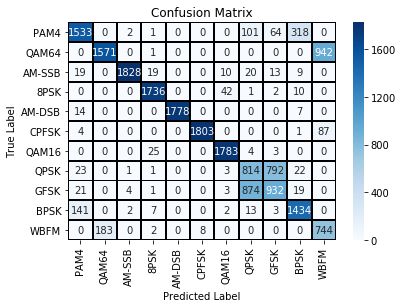

In [0]:
show_confusion_matrix(Y_pred, Y_test)